In [2]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from transformers import AutoProcessor, WavLMForSequenceClassification, AutoConfig
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from tqdm import tqdm
import pickle
import torch.nn.functional as F
import numpy as np
from google.colab import drive

# Google Drive'ı bağla
drive.mount('/content/drive')

output_dir = "/content/drive/MyDrive/model"  # Google Drive'a kaydetme dizini

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# AudioDataset Sınıfı
class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels, processor, target_length=160000):
        self.audio_paths = audio_paths
        self.labels = labels
        self.processor = processor
        self.target_length = target_length

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        file_path = self.audio_paths[idx]
        label = self.labels[idx]
        waveform, sr = torchaudio.load(file_path)
        waveform = waveform.squeeze()

        # Eğer ses uzunluğu target_length'ten küçükse padding ekle
        if waveform.size(0) < self.target_length:
            waveform = F.pad(waveform, (0, self.target_length - waveform.size(0)))
        else:
            waveform = waveform[:self.target_length]

        # Input verisini işleme
        inputs = self.processor(waveform, sampling_rate=16000, return_tensors="pt", padding=True)
        return inputs.input_values[0], label

# Veri Yükleme Fonksiyonu
def load_data(base_dir, categories, notes):
    file_paths, labels = [], []
    label_map = {note: idx for idx, note in enumerate(notes)}

    for category in categories:
        for note in notes:
            path = os.path.join(base_dir, category, note)
            if not os.path.exists(path):
                print(f"Warning: {path} does not exist.")
                continue
            files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith(".wav")]
            file_paths.extend(files)
            labels.extend([label_map[note]] * len(files))
    return file_paths, labels

# Collate Function
def collate_fn(batch):
    inputs = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    inputs_padded = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True)
    return inputs_padded, torch.tensor(labels)

# Modeli eğitirken giriş verisini float32'ye dönüştür
def train_model(train_loader, val_loader, model, processor, epochs=100, output_dir=output_dir):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    loss_fn = torch.nn.CrossEntropyLoss()
    model.to(device)

    global best_accuracy  # Global değişken olarak tanımla
    best_accuracy = 0  # En iyi doğruluk değerini sıfırla
    metrics_history = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        train_preds, train_targets = [], []
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}") as pbar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Veriyi float32'ye dönüştür
                inputs = inputs.to(torch.float32)

                optimizer.zero_grad()
                outputs = model(inputs).logits
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
                train_preds.extend(torch.argmax(outputs, axis=1).cpu().numpy())
                train_targets.extend(labels.cpu().numpy())
                pbar.update(1)

        # Eğitim doğruluğu hesapla
        train_accuracy = accuracy_score(train_targets, train_preds)
        print(f"Epoch {epoch + 1}: Train Loss: {total_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        model.eval()
        total_val_loss = 0
        val_targets, val_preds = [], []
        val_probs = []
        fpr, tpr, roc_auc = {}, {}, {}
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Veriyi float32'ye dönüştür
                inputs = inputs.to(torch.float32)

                outputs = model(inputs).logits
                loss = loss_fn(outputs, labels)
                total_val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, axis=1).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
                val_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())  # Probabilities for each class

        # Validation metriklerini hesapla
        val_accuracy = accuracy_score(val_targets, val_preds)
        precision = precision_score(val_targets, val_preds, average="weighted", zero_division=1)
        recall = recall_score(val_targets, val_preds, average="weighted", zero_division=1)
        f1 = f1_score(val_targets, val_preds, average="weighted", zero_division=1)

        # ROC ve AUC hesapla
        valid_labels = np.unique(val_targets)  # Geçerli sınıfları al
        for i in valid_labels:
            fpr[i], tpr[i], _ = roc_curve(val_targets, np.array(val_probs)[:, i], pos_label=i)
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Macro ROC AUC hesapla
        all_fpr = np.unique(np.concatenate([fpr[i] for i in valid_labels]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in valid_labels:
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        mean_tpr /= len(valid_labels)
        macro_roc_auc = auc(all_fpr, mean_tpr)

        metrics = {"epoch": epoch + 1, "train_accuracy": train_accuracy, "val_accuracy": val_accuracy,
                   "train_loss": total_train_loss, "val_loss": total_val_loss, "precision": precision,
                   "recall": recall, "f1": f1, "roc_auc": roc_auc, "macro_roc_auc": macro_roc_auc,
                   "fpr": fpr, "tpr": tpr}  # fpr ve tpr değerleri ekleniyor

        metrics_history.append(metrics)
        print(f"Epoch {epoch + 1}: Train Loss: {total_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Train Loss: {total_train_loss:.4f}, Validation Loss: {total_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Macro ROC AUC: {macro_roc_auc:.4f}")

        save_model_and_metrics(model, epoch, metrics_history, output_dir, val_accuracy)


# Modeli ve metrikleri kaydetme fonksiyonu
def save_model_and_metrics(model, epoch, metrics_history, output_dir, accuracy):
    global best_accuracy  # Fonksiyon içinde global değişkene erişim sağla

    # Klasörlerin olup olmadığını kontrol et ve oluştur
    model_output_dir = os.path.join(output_dir, "wavlm")
    if not os.path.exists(model_output_dir):
        os.makedirs(model_output_dir)

    # .best.pt sadece en iyi doğrulukla kaydedilecek
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), os.path.join(model_output_dir, "wavlm_best.pt"))

    # .last.pt her zaman son epoch'la kaydedilecek
    torch.save(model.state_dict(), os.path.join(model_output_dir, "wavlm_last.pt"))

    # Metrikleri kaydet
    with open(os.path.join(model_output_dir, "metrics.pkl"), "wb") as f:
        pickle.dump(metrics_history, f)


# Google Drive'daki 'model/wavlm' klasörünü kullanacak şekilde güncelleme
base_dir = "/content/drive/MyDrive/processed"  # MyDrive altında 'processed' klasörünüz var

train_audio_paths, train_labels = load_data(os.path.join(base_dir, "train"), ["akortlu", "akortsuz"], ["Do", "Do#", "Re", "Re#", "Mi", "Fa", "Fa#", "Sol", "Sol#", "La", "La#", "Si"])
val_audio_paths, val_labels = load_data(os.path.join(base_dir, "val"), ["akortlu", "akortsuz"], ["Do", "Do#", "Re", "Re#", "Mi", "Fa", "Fa#", "Sol", "Sol#", "La", "La#", "Si"])

# WavLM işlemcisi ve model yükleme
processor = AutoProcessor.from_pretrained("patrickvonplaten/wavlm-libri-clean-100h-base-plus")
model = WavLMForSequenceClassification.from_pretrained("patrickvonplaten/wavlm-libri-clean-100h-base-plus", num_labels=12)

# Model ağırlıklarını float32 olarak yükleyelim
model = model.to(device).float()

train_dataset = AudioDataset(train_audio_paths, train_labels, processor)
val_dataset = AudioDataset(val_audio_paths, val_labels, processor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

train_model(train_loader, val_loader, model, processor)


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.27k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/259 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of WavLMForSequenceClassification were not initialized from the model checkpoint at patrickvonplaten/wavlm-libri-clean-100h-base-plus and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/100: 100%|██████████| 102/102 [22:01<00:00, 12.96s/it]


Epoch 1: Train Loss: 253.2007, Train Accuracy: 0.0875
Epoch 1: Train Loss: 253.2007, Train Accuracy: 0.0875, Train Loss: 253.2007, Validation Loss: 34.7163, Validation Accuracy: 0.0957, Macro ROC AUC: 0.5433


Epoch 2/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 2: Train Loss: 249.9171, Train Accuracy: 0.1227
Epoch 2: Train Loss: 249.9171, Train Accuracy: 0.1227, Train Loss: 249.9171, Validation Loss: 33.5228, Validation Accuracy: 0.1531, Macro ROC AUC: 0.6752


Epoch 3/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 3: Train Loss: 235.5379, Train Accuracy: 0.1652
Epoch 3: Train Loss: 235.5379, Train Accuracy: 0.1652, Train Loss: 235.5379, Validation Loss: 31.1902, Validation Accuracy: 0.1986, Macro ROC AUC: 0.7531


Epoch 4/100: 100%|██████████| 102/102 [01:05<00:00,  1.55it/s]


Epoch 4: Train Loss: 220.0217, Train Accuracy: 0.2096
Epoch 4: Train Loss: 220.0217, Train Accuracy: 0.2096, Train Loss: 220.0217, Validation Loss: 29.3218, Validation Accuracy: 0.2273, Macro ROC AUC: 0.8158


Epoch 5/100: 100%|██████████| 102/102 [01:06<00:00,  1.53it/s]


Epoch 5: Train Loss: 200.3789, Train Accuracy: 0.2842
Epoch 5: Train Loss: 200.3789, Train Accuracy: 0.2842, Train Loss: 200.3789, Validation Loss: 26.8487, Validation Accuracy: 0.3206, Macro ROC AUC: 0.8798


Epoch 6/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 6: Train Loss: 181.0743, Train Accuracy: 0.3502
Epoch 6: Train Loss: 181.0743, Train Accuracy: 0.3502, Train Loss: 181.0743, Validation Loss: 24.6936, Validation Accuracy: 0.3445, Macro ROC AUC: 0.8941


Epoch 7/100: 100%|██████████| 102/102 [01:06<00:00,  1.54it/s]


Epoch 7: Train Loss: 167.6276, Train Accuracy: 0.4075
Epoch 7: Train Loss: 167.6276, Train Accuracy: 0.4075, Train Loss: 167.6276, Validation Loss: 23.7612, Validation Accuracy: 0.3565, Macro ROC AUC: 0.9052


Epoch 8/100: 100%|██████████| 102/102 [01:04<00:00,  1.58it/s]


Epoch 8: Train Loss: 156.5960, Train Accuracy: 0.4297
Epoch 8: Train Loss: 156.5960, Train Accuracy: 0.4297, Train Loss: 156.5960, Validation Loss: 21.9873, Validation Accuracy: 0.4234, Macro ROC AUC: 0.9181


Epoch 9/100: 100%|██████████| 102/102 [01:06<00:00,  1.54it/s]


Epoch 9: Train Loss: 143.9258, Train Accuracy: 0.5031
Epoch 9: Train Loss: 143.9258, Train Accuracy: 0.5031, Train Loss: 143.9258, Validation Loss: 20.3548, Validation Accuracy: 0.4402, Macro ROC AUC: 0.9261


Epoch 10/100: 100%|██████████| 102/102 [01:04<00:00,  1.58it/s]


Epoch 10: Train Loss: 130.6826, Train Accuracy: 0.5882
Epoch 10: Train Loss: 130.6826, Train Accuracy: 0.5882, Train Loss: 130.6826, Validation Loss: 19.0632, Validation Accuracy: 0.5335, Macro ROC AUC: 0.9427


Epoch 11/100: 100%|██████████| 102/102 [01:06<00:00,  1.54it/s]


Epoch 11: Train Loss: 122.4318, Train Accuracy: 0.6122
Epoch 11: Train Loss: 122.4318, Train Accuracy: 0.6122, Train Loss: 122.4318, Validation Loss: 18.6335, Validation Accuracy: 0.4976, Macro ROC AUC: 0.9430


Epoch 12/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 12: Train Loss: 111.5397, Train Accuracy: 0.6887
Epoch 12: Train Loss: 111.5397, Train Accuracy: 0.6887, Train Loss: 111.5397, Validation Loss: 17.7425, Validation Accuracy: 0.5000, Macro ROC AUC: 0.9387


Epoch 13/100: 100%|██████████| 102/102 [01:05<00:00,  1.55it/s]


Epoch 13: Train Loss: 100.1243, Train Accuracy: 0.7466
Epoch 13: Train Loss: 100.1243, Train Accuracy: 0.7466, Train Loss: 100.1243, Validation Loss: 14.7265, Validation Accuracy: 0.6483, Macro ROC AUC: 0.9637


Epoch 14/100: 100%|██████████| 102/102 [01:04<00:00,  1.57it/s]


Epoch 14: Train Loss: 91.6081, Train Accuracy: 0.7762
Epoch 14: Train Loss: 91.6081, Train Accuracy: 0.7762, Train Loss: 91.6081, Validation Loss: 14.1981, Validation Accuracy: 0.6459, Macro ROC AUC: 0.9653


Epoch 15/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 15: Train Loss: 83.4994, Train Accuracy: 0.7996
Epoch 15: Train Loss: 83.4994, Train Accuracy: 0.7996, Train Loss: 83.4994, Validation Loss: 13.5016, Validation Accuracy: 0.6388, Macro ROC AUC: 0.9696


Epoch 16/100: 100%|██████████| 102/102 [01:04<00:00,  1.59it/s]


Epoch 16: Train Loss: 77.5716, Train Accuracy: 0.8163
Epoch 16: Train Loss: 77.5716, Train Accuracy: 0.8163, Train Loss: 77.5716, Validation Loss: 12.6541, Validation Accuracy: 0.7297, Macro ROC AUC: 0.9770


Epoch 17/100: 100%|██████████| 102/102 [01:06<00:00,  1.54it/s]


Epoch 17: Train Loss: 72.3282, Train Accuracy: 0.8107
Epoch 17: Train Loss: 72.3282, Train Accuracy: 0.8107, Train Loss: 72.3282, Validation Loss: 13.8221, Validation Accuracy: 0.6603, Macro ROC AUC: 0.9642


Epoch 18/100: 100%|██████████| 102/102 [01:04<00:00,  1.58it/s]


Epoch 18: Train Loss: 67.0691, Train Accuracy: 0.8261
Epoch 18: Train Loss: 67.0691, Train Accuracy: 0.8261, Train Loss: 67.0691, Validation Loss: 10.6987, Validation Accuracy: 0.7153, Macro ROC AUC: 0.9780


Epoch 19/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 19: Train Loss: 56.8003, Train Accuracy: 0.8748
Epoch 19: Train Loss: 56.8003, Train Accuracy: 0.8748, Train Loss: 56.8003, Validation Loss: 10.2820, Validation Accuracy: 0.7297, Macro ROC AUC: 0.9790


Epoch 20/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 20: Train Loss: 56.2060, Train Accuracy: 0.8576
Epoch 20: Train Loss: 56.2060, Train Accuracy: 0.8576, Train Loss: 56.2060, Validation Loss: 8.2637, Validation Accuracy: 0.8158, Macro ROC AUC: 0.9874


Epoch 21/100: 100%|██████████| 102/102 [01:06<00:00,  1.53it/s]


Epoch 21: Train Loss: 45.8642, Train Accuracy: 0.9038
Epoch 21: Train Loss: 45.8642, Train Accuracy: 0.9038, Train Loss: 45.8642, Validation Loss: 7.9358, Validation Accuracy: 0.8349, Macro ROC AUC: 0.9888


Epoch 22/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 22: Train Loss: 41.6321, Train Accuracy: 0.9174
Epoch 22: Train Loss: 41.6321, Train Accuracy: 0.9174, Train Loss: 41.6321, Validation Loss: 7.8951, Validation Accuracy: 0.7943, Macro ROC AUC: 0.9868


Epoch 23/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 23: Train Loss: 44.3347, Train Accuracy: 0.8890
Epoch 23: Train Loss: 44.3347, Train Accuracy: 0.8890, Train Loss: 44.3347, Validation Loss: 11.7849, Validation Accuracy: 0.7440, Macro ROC AUC: 0.9766


Epoch 24/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 24: Train Loss: 41.9483, Train Accuracy: 0.8859
Epoch 24: Train Loss: 41.9483, Train Accuracy: 0.8859, Train Loss: 41.9483, Validation Loss: 7.0547, Validation Accuracy: 0.8254, Macro ROC AUC: 0.9886


Epoch 25/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 25: Train Loss: 38.1525, Train Accuracy: 0.9044
Epoch 25: Train Loss: 38.1525, Train Accuracy: 0.9044, Train Loss: 38.1525, Validation Loss: 9.3093, Validation Accuracy: 0.7440, Macro ROC AUC: 0.9804


Epoch 26/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 26: Train Loss: 36.4975, Train Accuracy: 0.9100
Epoch 26: Train Loss: 36.4975, Train Accuracy: 0.9100, Train Loss: 36.4975, Validation Loss: 7.5181, Validation Accuracy: 0.8038, Macro ROC AUC: 0.9872


Epoch 27/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 27: Train Loss: 32.2450, Train Accuracy: 0.9303
Epoch 27: Train Loss: 32.2450, Train Accuracy: 0.9303, Train Loss: 32.2450, Validation Loss: 6.5166, Validation Accuracy: 0.8397, Macro ROC AUC: 0.9894


Epoch 28/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 28: Train Loss: 26.6851, Train Accuracy: 0.9433
Epoch 28: Train Loss: 26.6851, Train Accuracy: 0.9433, Train Loss: 26.6851, Validation Loss: 8.3137, Validation Accuracy: 0.7775, Macro ROC AUC: 0.9850


Epoch 29/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 29: Train Loss: 25.5711, Train Accuracy: 0.9470
Epoch 29: Train Loss: 25.5711, Train Accuracy: 0.9470, Train Loss: 25.5711, Validation Loss: 8.5105, Validation Accuracy: 0.8206, Macro ROC AUC: 0.9875


Epoch 30/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 30: Train Loss: 39.6028, Train Accuracy: 0.8896
Epoch 30: Train Loss: 39.6028, Train Accuracy: 0.8896, Train Loss: 39.6028, Validation Loss: 11.6226, Validation Accuracy: 0.7392, Macro ROC AUC: 0.9805


Epoch 31/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 31: Train Loss: 28.6171, Train Accuracy: 0.9309
Epoch 31: Train Loss: 28.6171, Train Accuracy: 0.9309, Train Loss: 28.6171, Validation Loss: 8.2756, Validation Accuracy: 0.7823, Macro ROC AUC: 0.9840


Epoch 32/100: 100%|██████████| 102/102 [01:04<00:00,  1.59it/s]


Epoch 32: Train Loss: 28.6699, Train Accuracy: 0.9236
Epoch 32: Train Loss: 28.6699, Train Accuracy: 0.9236, Train Loss: 28.6699, Validation Loss: 11.3068, Validation Accuracy: 0.7823, Macro ROC AUC: 0.9856


Epoch 33/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 33: Train Loss: 27.9792, Train Accuracy: 0.9199
Epoch 33: Train Loss: 27.9792, Train Accuracy: 0.9199, Train Loss: 27.9792, Validation Loss: 10.4850, Validation Accuracy: 0.7392, Macro ROC AUC: 0.9761


Epoch 34/100: 100%|██████████| 102/102 [01:04<00:00,  1.58it/s]


Epoch 34: Train Loss: 30.5509, Train Accuracy: 0.9137
Epoch 34: Train Loss: 30.5509, Train Accuracy: 0.9137, Train Loss: 30.5509, Validation Loss: 5.3074, Validation Accuracy: 0.8828, Macro ROC AUC: 0.9921


Epoch 35/100: 100%|██████████| 102/102 [01:06<00:00,  1.54it/s]


Epoch 35: Train Loss: 19.3615, Train Accuracy: 0.9599
Epoch 35: Train Loss: 19.3615, Train Accuracy: 0.9599, Train Loss: 19.3615, Validation Loss: 6.1558, Validation Accuracy: 0.8469, Macro ROC AUC: 0.9904


Epoch 36/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 36: Train Loss: 19.5088, Train Accuracy: 0.9612
Epoch 36: Train Loss: 19.5088, Train Accuracy: 0.9612, Train Loss: 19.5088, Validation Loss: 7.2357, Validation Accuracy: 0.8804, Macro ROC AUC: 0.9926


Epoch 37/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 37: Train Loss: 20.1503, Train Accuracy: 0.9556
Epoch 37: Train Loss: 20.1503, Train Accuracy: 0.9556, Train Loss: 20.1503, Validation Loss: 6.0495, Validation Accuracy: 0.8589, Macro ROC AUC: 0.9897


Epoch 38/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 38: Train Loss: 23.5033, Train Accuracy: 0.9408
Epoch 38: Train Loss: 23.5033, Train Accuracy: 0.9408, Train Loss: 23.5033, Validation Loss: 7.6505, Validation Accuracy: 0.8110, Macro ROC AUC: 0.9875


Epoch 39/100: 100%|██████████| 102/102 [01:04<00:00,  1.58it/s]


Epoch 39: Train Loss: 23.6682, Train Accuracy: 0.9396
Epoch 39: Train Loss: 23.6682, Train Accuracy: 0.9396, Train Loss: 23.6682, Validation Loss: 7.2998, Validation Accuracy: 0.8230, Macro ROC AUC: 0.9887


Epoch 40/100: 100%|██████████| 102/102 [01:04<00:00,  1.59it/s]


Epoch 40: Train Loss: 22.6535, Train Accuracy: 0.9377
Epoch 40: Train Loss: 22.6535, Train Accuracy: 0.9377, Train Loss: 22.6535, Validation Loss: 8.5251, Validation Accuracy: 0.7584, Macro ROC AUC: 0.9869


Epoch 41/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 41: Train Loss: 25.7546, Train Accuracy: 0.9279
Epoch 41: Train Loss: 25.7546, Train Accuracy: 0.9279, Train Loss: 25.7546, Validation Loss: 5.6144, Validation Accuracy: 0.8589, Macro ROC AUC: 0.9916


Epoch 42/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 42: Train Loss: 20.1289, Train Accuracy: 0.9494
Epoch 42: Train Loss: 20.1289, Train Accuracy: 0.9494, Train Loss: 20.1289, Validation Loss: 8.7627, Validation Accuracy: 0.8182, Macro ROC AUC: 0.9861


Epoch 43/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 43: Train Loss: 16.4676, Train Accuracy: 0.9630
Epoch 43: Train Loss: 16.4676, Train Accuracy: 0.9630, Train Loss: 16.4676, Validation Loss: 6.4590, Validation Accuracy: 0.8517, Macro ROC AUC: 0.9893


Epoch 44/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 44: Train Loss: 19.8975, Train Accuracy: 0.9488
Epoch 44: Train Loss: 19.8975, Train Accuracy: 0.9488, Train Loss: 19.8975, Validation Loss: 6.9527, Validation Accuracy: 0.8254, Macro ROC AUC: 0.9887


Epoch 45/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 45: Train Loss: 17.9156, Train Accuracy: 0.9587
Epoch 45: Train Loss: 17.9156, Train Accuracy: 0.9587, Train Loss: 17.9156, Validation Loss: 5.9998, Validation Accuracy: 0.8708, Macro ROC AUC: 0.9907


Epoch 46/100: 100%|██████████| 102/102 [01:04<00:00,  1.58it/s]


Epoch 46: Train Loss: 14.7252, Train Accuracy: 0.9673
Epoch 46: Train Loss: 14.7252, Train Accuracy: 0.9673, Train Loss: 14.7252, Validation Loss: 6.9057, Validation Accuracy: 0.8230, Macro ROC AUC: 0.9910


Epoch 47/100: 100%|██████████| 102/102 [01:04<00:00,  1.57it/s]


Epoch 47: Train Loss: 32.6333, Train Accuracy: 0.9038
Epoch 47: Train Loss: 32.6333, Train Accuracy: 0.9038, Train Loss: 32.6333, Validation Loss: 6.8840, Validation Accuracy: 0.8373, Macro ROC AUC: 0.9881


Epoch 48/100: 100%|██████████| 102/102 [01:04<00:00,  1.58it/s]


Epoch 48: Train Loss: 14.3174, Train Accuracy: 0.9692
Epoch 48: Train Loss: 14.3174, Train Accuracy: 0.9692, Train Loss: 14.3174, Validation Loss: 6.6227, Validation Accuracy: 0.8732, Macro ROC AUC: 0.9911


Epoch 49/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 49: Train Loss: 11.5544, Train Accuracy: 0.9809
Epoch 49: Train Loss: 11.5544, Train Accuracy: 0.9809, Train Loss: 11.5544, Validation Loss: 5.3658, Validation Accuracy: 0.8852, Macro ROC AUC: 0.9920


Epoch 50/100: 100%|██████████| 102/102 [01:04<00:00,  1.58it/s]


Epoch 50: Train Loss: 13.7802, Train Accuracy: 0.9729
Epoch 50: Train Loss: 13.7802, Train Accuracy: 0.9729, Train Loss: 13.7802, Validation Loss: 5.2400, Validation Accuracy: 0.8852, Macro ROC AUC: 0.9913


Epoch 51/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 51: Train Loss: 17.3429, Train Accuracy: 0.9581
Epoch 51: Train Loss: 17.3429, Train Accuracy: 0.9581, Train Loss: 17.3429, Validation Loss: 6.7189, Validation Accuracy: 0.8541, Macro ROC AUC: 0.9883


Epoch 52/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 52: Train Loss: 15.2774, Train Accuracy: 0.9624
Epoch 52: Train Loss: 15.2774, Train Accuracy: 0.9624, Train Loss: 15.2774, Validation Loss: 7.1362, Validation Accuracy: 0.8589, Macro ROC AUC: 0.9864


Epoch 53/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 53: Train Loss: 17.5392, Train Accuracy: 0.9562
Epoch 53: Train Loss: 17.5392, Train Accuracy: 0.9562, Train Loss: 17.5392, Validation Loss: 6.6208, Validation Accuracy: 0.8541, Macro ROC AUC: 0.9889


Epoch 54/100: 100%|██████████| 102/102 [01:04<00:00,  1.58it/s]


Epoch 54: Train Loss: 14.4709, Train Accuracy: 0.9673
Epoch 54: Train Loss: 14.4709, Train Accuracy: 0.9673, Train Loss: 14.4709, Validation Loss: 7.9521, Validation Accuracy: 0.8469, Macro ROC AUC: 0.9817


Epoch 55/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 55: Train Loss: 15.1241, Train Accuracy: 0.9636
Epoch 55: Train Loss: 15.1241, Train Accuracy: 0.9636, Train Loss: 15.1241, Validation Loss: 5.3992, Validation Accuracy: 0.8828, Macro ROC AUC: 0.9912


Epoch 56/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 56: Train Loss: 14.9876, Train Accuracy: 0.9630
Epoch 56: Train Loss: 14.9876, Train Accuracy: 0.9630, Train Loss: 14.9876, Validation Loss: 6.3984, Validation Accuracy: 0.8780, Macro ROC AUC: 0.9890


Epoch 57/100: 100%|██████████| 102/102 [01:04<00:00,  1.59it/s]


Epoch 57: Train Loss: 14.3231, Train Accuracy: 0.9661
Epoch 57: Train Loss: 14.3231, Train Accuracy: 0.9661, Train Loss: 14.3231, Validation Loss: 6.5579, Validation Accuracy: 0.8565, Macro ROC AUC: 0.9901


Epoch 58/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 58: Train Loss: 11.2656, Train Accuracy: 0.9729
Epoch 58: Train Loss: 11.2656, Train Accuracy: 0.9729, Train Loss: 11.2656, Validation Loss: 5.7169, Validation Accuracy: 0.8780, Macro ROC AUC: 0.9908


Epoch 59/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 59: Train Loss: 11.4780, Train Accuracy: 0.9766
Epoch 59: Train Loss: 11.4780, Train Accuracy: 0.9766, Train Loss: 11.4780, Validation Loss: 5.6456, Validation Accuracy: 0.8852, Macro ROC AUC: 0.9909


Epoch 60/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 60: Train Loss: 20.9356, Train Accuracy: 0.9420
Epoch 60: Train Loss: 20.9356, Train Accuracy: 0.9420, Train Loss: 20.9356, Validation Loss: 7.8339, Validation Accuracy: 0.8349, Macro ROC AUC: 0.9849


Epoch 61/100: 100%|██████████| 102/102 [01:04<00:00,  1.58it/s]


Epoch 61: Train Loss: 17.4099, Train Accuracy: 0.9550
Epoch 61: Train Loss: 17.4099, Train Accuracy: 0.9550, Train Loss: 17.4099, Validation Loss: 6.5619, Validation Accuracy: 0.8612, Macro ROC AUC: 0.9899


Epoch 62/100: 100%|██████████| 102/102 [01:05<00:00,  1.55it/s]


Epoch 62: Train Loss: 13.0472, Train Accuracy: 0.9704
Epoch 62: Train Loss: 13.0472, Train Accuracy: 0.9704, Train Loss: 13.0472, Validation Loss: 6.1285, Validation Accuracy: 0.8589, Macro ROC AUC: 0.9918


Epoch 63/100: 100%|██████████| 102/102 [01:04<00:00,  1.58it/s]


Epoch 63: Train Loss: 13.6056, Train Accuracy: 0.9692
Epoch 63: Train Loss: 13.6056, Train Accuracy: 0.9692, Train Loss: 13.6056, Validation Loss: 6.0682, Validation Accuracy: 0.8828, Macro ROC AUC: 0.9900


Epoch 64/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 64: Train Loss: 11.4586, Train Accuracy: 0.9710
Epoch 64: Train Loss: 11.4586, Train Accuracy: 0.9710, Train Loss: 11.4586, Validation Loss: 6.8656, Validation Accuracy: 0.8565, Macro ROC AUC: 0.9894


Epoch 65/100: 100%|██████████| 102/102 [01:04<00:00,  1.57it/s]


Epoch 65: Train Loss: 16.3239, Train Accuracy: 0.9587
Epoch 65: Train Loss: 16.3239, Train Accuracy: 0.9587, Train Loss: 16.3239, Validation Loss: 5.2692, Validation Accuracy: 0.9019, Macro ROC AUC: 0.9916


Epoch 66/100: 100%|██████████| 102/102 [01:06<00:00,  1.53it/s]


Epoch 66: Train Loss: 16.9857, Train Accuracy: 0.9618
Epoch 66: Train Loss: 16.9857, Train Accuracy: 0.9618, Train Loss: 16.9857, Validation Loss: 5.9569, Validation Accuracy: 0.8923, Macro ROC AUC: 0.9902


Epoch 67/100: 100%|██████████| 102/102 [01:04<00:00,  1.58it/s]


Epoch 67: Train Loss: 13.4227, Train Accuracy: 0.9698
Epoch 67: Train Loss: 13.4227, Train Accuracy: 0.9698, Train Loss: 13.4227, Validation Loss: 6.7633, Validation Accuracy: 0.8445, Macro ROC AUC: 0.9894


Epoch 68/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 68: Train Loss: 19.4335, Train Accuracy: 0.9427
Epoch 68: Train Loss: 19.4335, Train Accuracy: 0.9427, Train Loss: 19.4335, Validation Loss: 5.5036, Validation Accuracy: 0.8780, Macro ROC AUC: 0.9914


Epoch 69/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 69: Train Loss: 13.2744, Train Accuracy: 0.9655
Epoch 69: Train Loss: 13.2744, Train Accuracy: 0.9655, Train Loss: 13.2744, Validation Loss: 7.9040, Validation Accuracy: 0.8493, Macro ROC AUC: 0.9879


Epoch 70/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 70: Train Loss: 10.5402, Train Accuracy: 0.9760
Epoch 70: Train Loss: 10.5402, Train Accuracy: 0.9760, Train Loss: 10.5402, Validation Loss: 9.8979, Validation Accuracy: 0.7943, Macro ROC AUC: 0.9807


Epoch 71/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 71: Train Loss: 9.8734, Train Accuracy: 0.9766
Epoch 71: Train Loss: 9.8734, Train Accuracy: 0.9766, Train Loss: 9.8734, Validation Loss: 6.8675, Validation Accuracy: 0.8684, Macro ROC AUC: 0.9878


Epoch 72/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 72: Train Loss: 17.1662, Train Accuracy: 0.9525
Epoch 72: Train Loss: 17.1662, Train Accuracy: 0.9525, Train Loss: 17.1662, Validation Loss: 10.7903, Validation Accuracy: 0.7895, Macro ROC AUC: 0.9787


Epoch 73/100: 100%|██████████| 102/102 [01:04<00:00,  1.59it/s]


Epoch 73: Train Loss: 14.8580, Train Accuracy: 0.9649
Epoch 73: Train Loss: 14.8580, Train Accuracy: 0.9649, Train Loss: 14.8580, Validation Loss: 6.0161, Validation Accuracy: 0.8780, Macro ROC AUC: 0.9898


Epoch 74/100: 100%|██████████| 102/102 [01:04<00:00,  1.59it/s]


Epoch 74: Train Loss: 11.6927, Train Accuracy: 0.9735
Epoch 74: Train Loss: 11.6927, Train Accuracy: 0.9735, Train Loss: 11.6927, Validation Loss: 5.0289, Validation Accuracy: 0.8971, Macro ROC AUC: 0.9927


Epoch 75/100: 100%|██████████| 102/102 [01:04<00:00,  1.58it/s]


Epoch 75: Train Loss: 15.9971, Train Accuracy: 0.9568
Epoch 75: Train Loss: 15.9971, Train Accuracy: 0.9568, Train Loss: 15.9971, Validation Loss: 6.3658, Validation Accuracy: 0.8636, Macro ROC AUC: 0.9907


Epoch 76/100: 100%|██████████| 102/102 [01:04<00:00,  1.57it/s]


Epoch 76: Train Loss: 18.5683, Train Accuracy: 0.9550
Epoch 76: Train Loss: 18.5683, Train Accuracy: 0.9550, Train Loss: 18.5683, Validation Loss: 7.0611, Validation Accuracy: 0.8565, Macro ROC AUC: 0.9867


Epoch 77/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 77: Train Loss: 14.3927, Train Accuracy: 0.9636
Epoch 77: Train Loss: 14.3927, Train Accuracy: 0.9636, Train Loss: 14.3927, Validation Loss: 8.7111, Validation Accuracy: 0.8349, Macro ROC AUC: 0.9844


Epoch 78/100: 100%|██████████| 102/102 [01:04<00:00,  1.58it/s]


Epoch 78: Train Loss: 12.0772, Train Accuracy: 0.9741
Epoch 78: Train Loss: 12.0772, Train Accuracy: 0.9741, Train Loss: 12.0772, Validation Loss: 5.9550, Validation Accuracy: 0.8804, Macro ROC AUC: 0.9915


Epoch 79/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 79: Train Loss: 12.4820, Train Accuracy: 0.9698
Epoch 79: Train Loss: 12.4820, Train Accuracy: 0.9698, Train Loss: 12.4820, Validation Loss: 5.0761, Validation Accuracy: 0.9019, Macro ROC AUC: 0.9914


Epoch 80/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 80: Train Loss: 12.4255, Train Accuracy: 0.9710
Epoch 80: Train Loss: 12.4255, Train Accuracy: 0.9710, Train Loss: 12.4255, Validation Loss: 5.2905, Validation Accuracy: 0.9067, Macro ROC AUC: 0.9911


Epoch 81/100: 100%|██████████| 102/102 [01:05<00:00,  1.55it/s]


Epoch 81: Train Loss: 11.0486, Train Accuracy: 0.9772
Epoch 81: Train Loss: 11.0486, Train Accuracy: 0.9772, Train Loss: 11.0486, Validation Loss: 5.3145, Validation Accuracy: 0.9091, Macro ROC AUC: 0.9903


Epoch 82/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 82: Train Loss: 6.4903, Train Accuracy: 0.9877
Epoch 82: Train Loss: 6.4903, Train Accuracy: 0.9877, Train Loss: 6.4903, Validation Loss: 4.9065, Validation Accuracy: 0.9115, Macro ROC AUC: 0.9920


Epoch 83/100: 100%|██████████| 102/102 [01:04<00:00,  1.58it/s]


Epoch 83: Train Loss: 8.0908, Train Accuracy: 0.9821
Epoch 83: Train Loss: 8.0908, Train Accuracy: 0.9821, Train Loss: 8.0908, Validation Loss: 5.9214, Validation Accuracy: 0.8852, Macro ROC AUC: 0.9905


Epoch 84/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 84: Train Loss: 15.0726, Train Accuracy: 0.9599
Epoch 84: Train Loss: 15.0726, Train Accuracy: 0.9599, Train Loss: 15.0726, Validation Loss: 5.5062, Validation Accuracy: 0.8876, Macro ROC AUC: 0.9927


Epoch 85/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 85: Train Loss: 9.0994, Train Accuracy: 0.9809
Epoch 85: Train Loss: 9.0994, Train Accuracy: 0.9809, Train Loss: 9.0994, Validation Loss: 7.1271, Validation Accuracy: 0.8612, Macro ROC AUC: 0.9881


Epoch 86/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 86: Train Loss: 9.8199, Train Accuracy: 0.9815
Epoch 86: Train Loss: 9.8199, Train Accuracy: 0.9815, Train Loss: 9.8199, Validation Loss: 5.5139, Validation Accuracy: 0.8900, Macro ROC AUC: 0.9919


Epoch 87/100: 100%|██████████| 102/102 [01:04<00:00,  1.57it/s]


Epoch 87: Train Loss: 11.7299, Train Accuracy: 0.9649
Epoch 87: Train Loss: 11.7299, Train Accuracy: 0.9649, Train Loss: 11.7299, Validation Loss: 6.6751, Validation Accuracy: 0.8636, Macro ROC AUC: 0.9910


Epoch 88/100: 100%|██████████| 102/102 [01:04<00:00,  1.58it/s]


Epoch 88: Train Loss: 11.0546, Train Accuracy: 0.9704
Epoch 88: Train Loss: 11.0546, Train Accuracy: 0.9704, Train Loss: 11.0546, Validation Loss: 4.3472, Validation Accuracy: 0.9187, Macro ROC AUC: 0.9932


Epoch 89/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 89: Train Loss: 14.2786, Train Accuracy: 0.9550
Epoch 89: Train Loss: 14.2786, Train Accuracy: 0.9550, Train Loss: 14.2786, Validation Loss: 8.4578, Validation Accuracy: 0.8325, Macro ROC AUC: 0.9868


Epoch 90/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 90: Train Loss: 17.6063, Train Accuracy: 0.9519
Epoch 90: Train Loss: 17.6063, Train Accuracy: 0.9519, Train Loss: 17.6063, Validation Loss: 6.2552, Validation Accuracy: 0.8660, Macro ROC AUC: 0.9907


Epoch 91/100: 100%|██████████| 102/102 [01:04<00:00,  1.59it/s]


Epoch 91: Train Loss: 15.7694, Train Accuracy: 0.9605
Epoch 91: Train Loss: 15.7694, Train Accuracy: 0.9605, Train Loss: 15.7694, Validation Loss: 4.8684, Validation Accuracy: 0.8995, Macro ROC AUC: 0.9938


Epoch 92/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 92: Train Loss: 6.5417, Train Accuracy: 0.9871
Epoch 92: Train Loss: 6.5417, Train Accuracy: 0.9871, Train Loss: 6.5417, Validation Loss: 5.9467, Validation Accuracy: 0.8804, Macro ROC AUC: 0.9912


Epoch 93/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 93: Train Loss: 12.6951, Train Accuracy: 0.9630
Epoch 93: Train Loss: 12.6951, Train Accuracy: 0.9630, Train Loss: 12.6951, Validation Loss: 6.2784, Validation Accuracy: 0.8756, Macro ROC AUC: 0.9902


Epoch 94/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 94: Train Loss: 13.5302, Train Accuracy: 0.9593
Epoch 94: Train Loss: 13.5302, Train Accuracy: 0.9593, Train Loss: 13.5302, Validation Loss: 6.9611, Validation Accuracy: 0.8732, Macro ROC AUC: 0.9894


Epoch 95/100: 100%|██████████| 102/102 [01:04<00:00,  1.57it/s]


Epoch 95: Train Loss: 12.2820, Train Accuracy: 0.9704
Epoch 95: Train Loss: 12.2820, Train Accuracy: 0.9704, Train Loss: 12.2820, Validation Loss: 6.9477, Validation Accuracy: 0.8780, Macro ROC AUC: 0.9873


Epoch 96/100: 100%|██████████| 102/102 [01:05<00:00,  1.55it/s]


Epoch 96: Train Loss: 10.2500, Train Accuracy: 0.9778
Epoch 96: Train Loss: 10.2500, Train Accuracy: 0.9778, Train Loss: 10.2500, Validation Loss: 5.2550, Validation Accuracy: 0.9019, Macro ROC AUC: 0.9932


Epoch 97/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 97: Train Loss: 8.4572, Train Accuracy: 0.9753
Epoch 97: Train Loss: 8.4572, Train Accuracy: 0.9753, Train Loss: 8.4572, Validation Loss: 7.4818, Validation Accuracy: 0.8493, Macro ROC AUC: 0.9879


Epoch 98/100: 100%|██████████| 102/102 [01:04<00:00,  1.58it/s]


Epoch 98: Train Loss: 13.5707, Train Accuracy: 0.9630
Epoch 98: Train Loss: 13.5707, Train Accuracy: 0.9630, Train Loss: 13.5707, Validation Loss: 7.3257, Validation Accuracy: 0.8565, Macro ROC AUC: 0.9884


Epoch 99/100: 100%|██████████| 102/102 [01:05<00:00,  1.56it/s]


Epoch 99: Train Loss: 12.9749, Train Accuracy: 0.9692
Epoch 99: Train Loss: 12.9749, Train Accuracy: 0.9692, Train Loss: 12.9749, Validation Loss: 6.3560, Validation Accuracy: 0.8636, Macro ROC AUC: 0.9920


Epoch 100/100: 100%|██████████| 102/102 [01:05<00:00,  1.57it/s]


Epoch 100: Train Loss: 14.6650, Train Accuracy: 0.9581
Epoch 100: Train Loss: 14.6650, Train Accuracy: 0.9581, Train Loss: 14.6650, Validation Loss: 6.1318, Validation Accuracy: 0.8708, Macro ROC AUC: 0.9906


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


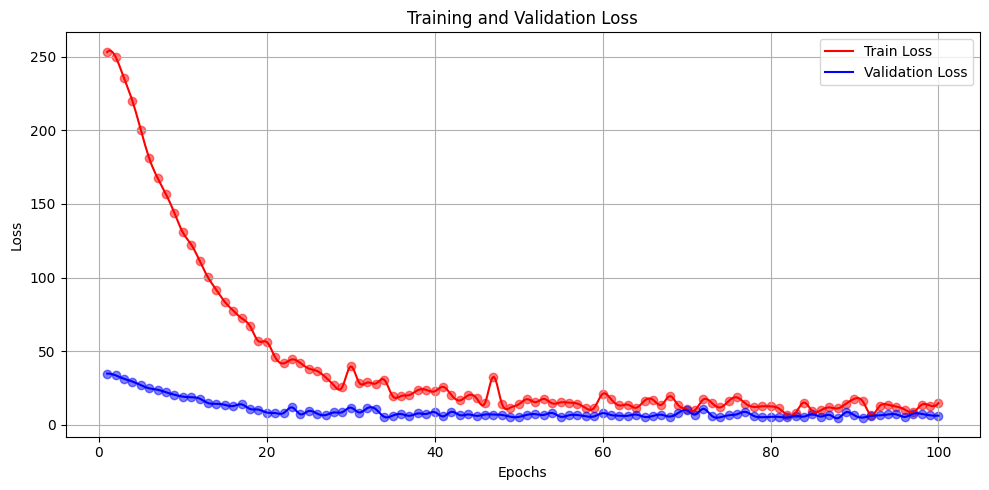

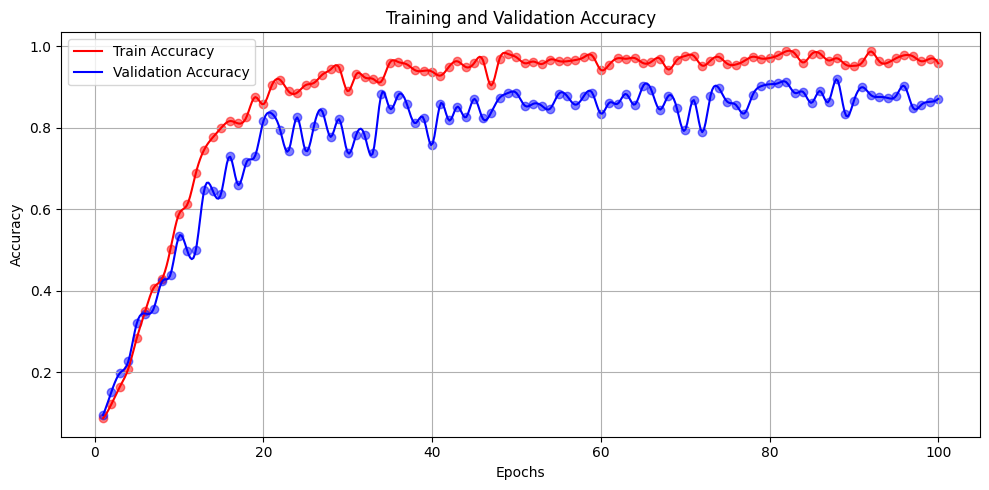

In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
from google.colab import drive

# Google Drive'ı bağla
drive.mount('/content/drive')

# 'metrics.pkl' dosyasını okuyun
def load_metrics(file_path):
    with open(file_path, "rb") as f:
        metrics_history = pickle.load(f)
    return metrics_history

def plot_metrics_from_file(metrics_history):
    # Epoch numaralarını alın
    epochs = [metrics["epoch"] for metrics in metrics_history]

    # Eğitim ve doğrulama kaybı ve doğruluğunu al
    train_losses = [metrics["train_loss"] for metrics in metrics_history]
    val_losses = [metrics["val_loss"] for metrics in metrics_history]
    train_accuracies = [metrics["train_accuracy"] for metrics in metrics_history]
    val_accuracies = [metrics["val_accuracy"] for metrics in metrics_history]

    # Daha sık aralıklarla epoch değerleri oluşturun
    epochs_new = np.linspace(min(epochs), max(epochs), 500)

    # Kaybı çizmek için spline interpolasyonu
    train_loss_spline = make_interp_spline(epochs, train_losses, k=3)
    train_loss_interpolated = train_loss_spline(epochs_new)

    val_loss_spline = make_interp_spline(epochs, val_losses, k=3)
    val_loss_interpolated = val_loss_spline(epochs_new)

    # Kaybı çiz
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_new, train_loss_interpolated, 'r', label='Train Loss')
    plt.plot(epochs_new, val_loss_interpolated, 'b', label='Validation Loss')
    plt.scatter(epochs, train_losses, color='r', alpha=0.5)
    plt.scatter(epochs, val_losses, color='b', alpha=0.5)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.tight_layout()  # Grafiklerin sıkışıklığını azaltmak için
    plt.show()
    plt.close()

    # Doğruluğu çizmek için spline interpolasyonu
    train_acc_spline = make_interp_spline(epochs, train_accuracies, k=3)
    train_acc_interpolated = train_acc_spline(epochs_new)

    val_acc_spline = make_interp_spline(epochs, val_accuracies, k=3)
    val_acc_interpolated = val_acc_spline(epochs_new)

    # Doğruluğu çiz
    plt.figure(figsize=(10, 5))
    plt.plot(epochs_new, train_acc_interpolated, 'r', label='Train Accuracy')
    plt.plot(epochs_new, val_acc_interpolated, 'b', label='Validation Accuracy')
    plt.scatter(epochs, train_accuracies, color='r', alpha=0.5)
    plt.scatter(epochs, val_accuracies, color='b', alpha=0.5)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.tight_layout()  # Grafiklerin sıkışıklığını azaltmak için
    plt.show()
    plt.close()

# 'metrics.pkl' dosyasının bulunduğu yolu girin
metrics_file_path = "/content/drive/MyDrive/model/wavlm100/metrics.pkl"

# Metrics verilerini yükleyin
metrics_history = load_metrics(metrics_file_path)

# Grafikleri çizdirin
plot_metrics_from_file(metrics_history)
